# Meteo 515 – Assignment 3 – Linear Regression

In [1]:
from __future__ import division, print_function
#from collections import OrderedDict
from itertools import chain
#import datetime as dt

#import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize as so
import scipy.stats as ss
#import sklearn as skl
import statsmodels.api as sm

In [2]:
plt.style.use('seaborn-darkgrid')
%matplotlib notebook

## Load the data

We are using [this dataset](https://esrl.noaa.gov/psd/data/correlation/amon.us.long.mean.data), the not-detrended and unsmoothed AMO index from NOAA ESRL. More info here: https://esrl.noaa.gov/psd/data/timeseries/AMO/

<div class="alert alert-info">
<strong>Note:</strong> Currently (27-Sep-18 10:00 EST) the data on the site is messed up for 1980 onwards, though it was fine when I downloaded it the day before.
</div>

In [3]:
amo_fpath = './data/amon.us.long.mean.data'

amo_raw = np.genfromtxt(amo_fpath, skip_header=1, skip_footer=7)[:,1:]

with open(amo_fpath, 'r') as f: yr_range = f.readline().split()
t_amo = pd.date_range(start='{}/01/01'.format(yr_range[0]), freq='MS', periods=amo_raw.size)
amo_ndt_us = amo_raw.reshape((amo_raw.size,))

amo = pd.DataFrame({'amo': amo_ndt_us}, index=t_amo)
amo['julian_date'] = amo.index.to_julian_date()               # Julian Date (decimal days)
amo['t_elapsed'] = amo.julian_date - amo.julian_date.iloc[0]  # elapsed time (decimal days)
amo['year'] = amo.index.year                                  # integer year for each data point
amo['decyear'] = amo.index.year + (amo.index.month-1)/12      # decimal year

amo[amo == -99.99] = np.nan
amo.dropna(inplace=True)

#> don't include 2018 in the annual means, since 4 months are missing
grouped = amo.loc[amo.year<=2017, :].groupby(pd.Grouper(freq='A'))
amo_annual_mean = grouped.mean()
amo_annual_mean['sem_annual'] = grouped.amo.std().values / np.sqrt(12)  # stdev of the mean; the initial data is monthly 
# ^ note that this gives indices that are the last day of the year
#   and {year}.46 for decimal year, since initially the datetimes are first day of the year

In [4]:
#> could make some routines here so I am not repeating so much below...
def res_plot(res):
    pass

## 1) Simple linear regression with year as predictor

<IPython.core.display.Javascript object>


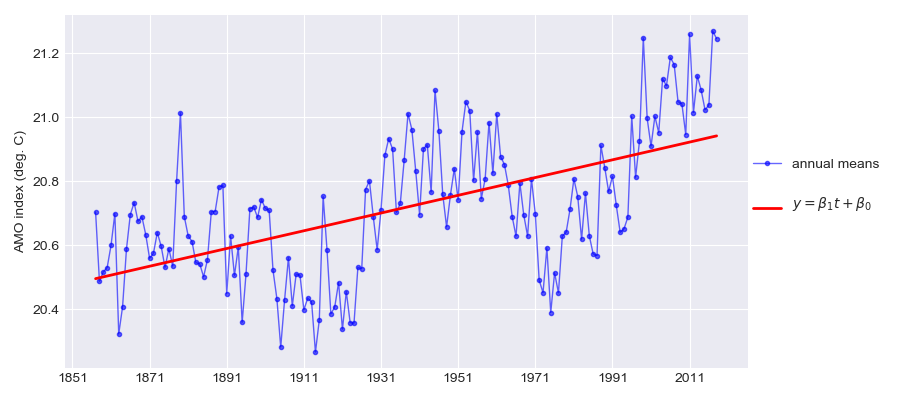

                            OLS Regression Results                            
Dep. Variable:                    amo   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     82.56
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           3.73e-16
Time:                        15:48:35   Log-Likelihood:                 47.402
No. Observations:                 162   AIC:                            -90.80
Df Residuals:                     160   BIC:                            -84.63
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         15.3469      0.591     25.952      0.0

<IPython.core.display.Javascript object>


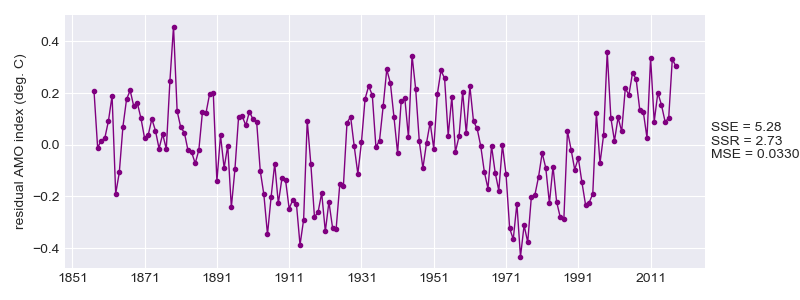

In [5]:
df_reg = amo_annual_mean  # gives slightly different answers, at least for error!. maybe becaues including the partial year?
t_reg = df_reg.year
t_plot = df_reg.index

res = sm.OLS(df_reg['amo'], sm.add_constant(t_reg), ).fit()

figsize = (9, 4.0)
figsize_res = (8, 3)
f1, a = plt.subplots(figsize=figsize, num='ts_ols1')

print(res.summary())  # note: can plot res using `sm.graphics.abline_plot(model_results=res)`

param_lines = '\n'.join([r'$\beta_{:d} = {{:.3g}} \pm {{:.3g}}$'.format(i) for i in range(len(res.params))])
s = r'$y=\beta_1 t + \beta_0$' + '\n'# + param_lines
s = s.format(*chain.from_iterable(zip(res.params, res.bse)))

y = amo_annual_mean['amo'].values
y_hat = t_reg*res.params[1]+res.params[0]

#a.plot(amo['amo'], 'b-.', alpha=0.3, ms=1, lw=0.5)  # monthly data
#xbar, se = amo_annual_mean.amo.values, amo_annual_mean.sem_annual.values
#a.fill_between(amo_annual_mean.index, xbar-1.*se, xbar+1.*se, alpha=0.3, label='SEM')
a.plot(t_plot, y, 'b.-', alpha=0.6, ms=6, lw=1, label='annual means')
a.plot(t_plot, y_hat, '-', c='r', lw=2, label=s)

#a.text(0.02, 0.98, s,
#       va='top', ha='left', transform=a.transAxes)

a.set_ylabel('AMO index (deg. C)')
a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f1.tight_layout();

f1b, a = plt.subplots(figsize=figsize_res, num='ts_ols1_res')

y_bar = y.mean()
SSE = np.sum((y-y_hat)**2)  # sum of squared error
SSR = np.sum((y_hat-y_bar)**2)  # residual sum of squares
SST = np.sum((y-y_bar)**2)
assert( np.isclose(SST, SSE+SSR) )
MSE = SSE/(res.df_resid)  # MSE == sample variance of the residuals
assert( np.isclose(MSE, res.mse_resid) )  # res.mse_model == MSR; F = MSR/MSE
s = '''
SSE = {:.3g}
SSR = {:.3g}
MSE = {:.4g}
'''.format(SSE, SSR, MSE)  

a.plot(t_plot, y-y_hat, '.-', c='purple', ms=6, lw=1, label=s)
a.set_ylabel('residual AMO index (deg. C)')
a.text(1.01, 0.5, s,
       va='center', ha='left', transform=a.transAxes)
#a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f1b.tight_layout(rect=(0, 0, 0.9, 1.0));

### Discussion:
asdf

## 2) Adding a prescribed oscillation

<IPython.core.display.Javascript object>


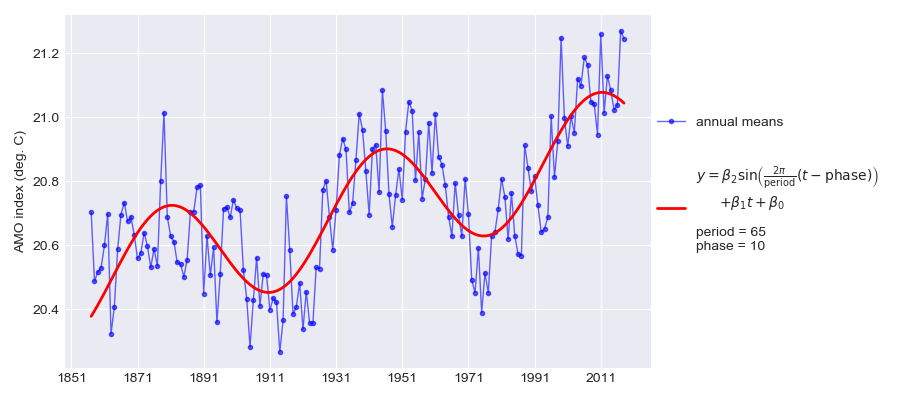

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     151.5
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           1.50e-37
Time:                        15:48:36   Log-Likelihood:                 100.09
No. Observations:                 162   AIC:                            -194.2
Df Residuals:                     159   BIC:                            -184.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
0-const          15.4385      0.429     36.021

<IPython.core.display.Javascript object>


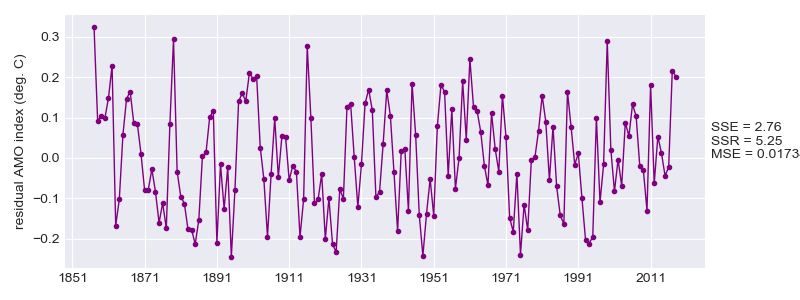

In [6]:
phase = 10  # years
period = 65  # in years

y = df_reg['amo'].values  # AMO index: annual mean of monthly mean AMO

x0 = np.ones(df_reg['amo'].shape)  # intercept
x1 = df_reg['year'].values  # year
x2 = np.sin(2*np.pi/period*(x1-phase))  # oscillation with prescribed period and phase

#X = np.vstack((x2, x1, x0)).T
X = pd.DataFrame(data={'0-const': x0, '1-year': x1, '2-oscillation': x2})

res = sm.OLS(y, X).fit()

y_hat = np.dot(X, res.params)

f2, a = plt.subplots(figsize=figsize, num='ts_ols2')

print(res.summary())

param_lines = '\n'.join([r'$\beta_{:d} = {{:.3g}} \pm {{:.3g}}$'.format(i) for i in range(len(res.params))])
s = r'''
$y = \beta_2 \sin\left( \frac{{2 \pi}}{{\mathrm{{period}}}} (t - \mathrm{{phase}}) \right)$ 
      $+ \beta_1 t + \beta_0$
      
period = {:d}
phase = {:d}
'''# + param_lines#).format(period, phase *stuff)
s = s.format(period, phase, *chain.from_iterable(zip(res.params, res.bse)))

a.plot(t_plot, y, 'b.-', alpha=0.6, ms=6, lw=1, label='annual means')
a.plot(t_plot, y_hat, '-', c='r', lw=2, label=s)

a.set_ylabel('AMO index (deg. C)')
a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f2.tight_layout()

f2b, a = plt.subplots(figsize=figsize_res, num='ts_ols2_res')

y_bar = y.mean()
SSE = np.sum((y-y_hat)**2)  # sum of squared error
SSR = np.sum((y_hat-y_bar)**2)  # residual sum of squares
SST = np.sum((y-y_bar)**2)
assert( np.isclose(SST, SSE+SSR) )
MSE = SSE/(res.df_resid)  # MSE == sample variance of the residuals
assert( np.isclose(MSE, res.mse_resid) )  # res.mse_model == MSR; F = MSR/MSE
s = '''
SSE = {:.3g}
SSR = {:.3g}
MSE = {:.4g}
'''.format(SSE, SSR, MSE)  

a.plot(t_plot, y-y_hat, '.-', c='purple', ms=6, lw=1, label=s)
a.set_ylabel('residual AMO index (deg. C)')
a.text(1.01, 0.5, s,
       va='center', ha='left', transform=a.transAxes)
#a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f2b.tight_layout(rect=(0, 0, 0.9, 1.0));

## 2.5) Find a better oscillation using optimization

<IPython.core.display.Javascript object>


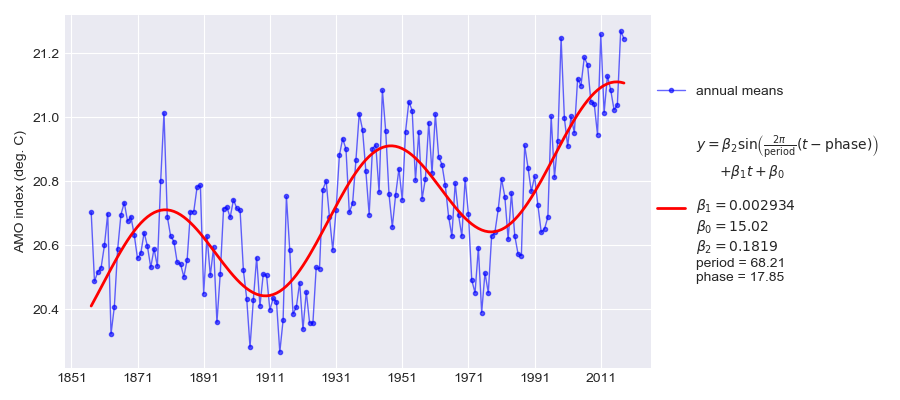

In [7]:
def fit1(t, slope, const, amp, period, phase):
    return amp*np.sin(2*np.pi/period*(t-phase)) + slope*t + const

popt, pcov = so.curve_fit(fit1, amo_annual_mean.year, amo_annual_mean.amo,
                          p0=(0.0027, 15.5, 0.18, 65, 50))

popt[-1] = popt[-1] % popt[-2]

f2p5, a = plt.subplots(figsize=figsize, num='ts_ols2.5')

#print(res.summary())

param_lines = '\n'.join([r'$\beta_{:d} = {{:.3g}} \pm {{:.3g}}$'.format(i) for i in range(len(res.params))])
s = r'''
$y = \beta_2 \sin\left( \frac{{2 \pi}}{{\mathrm{{period}}}} (t - \mathrm{{phase}}) \right)$ 
      $+ \beta_1 t + \beta_0$

$\beta_1 = {:.4g}$
$\beta_0 = {:.4g}$
$\beta_2 = {:.4g}$
period = {:.4g}
phase = {:.4g}
'''# + param_lines#).format(period, phase *stuff)
s = s.format(*popt)

a.plot(amo_annual_mean['amo'], 'b.-', alpha=0.6, ms=6, lw=1, label='annual means')
a.plot(t_plot, fit1(amo_annual_mean.year, *popt), '-', c='r', lw=2, label=s)

a.set_ylabel('AMO index (deg. C)')
a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f2p5.tight_layout();

### Discussion:
asdf

## 3) Same as (2), but linear trend predictor starts in 1900

Also, we will use the period and phase from the optimized fit in (2.5).

<IPython.core.display.Javascript object>


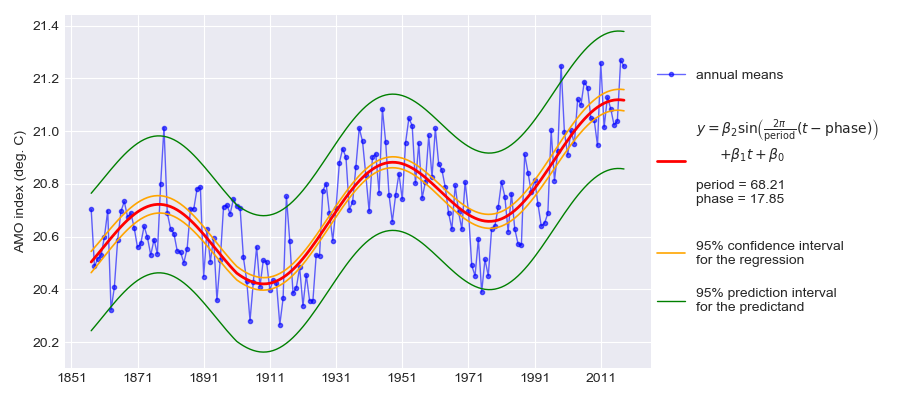

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     155.8
Date:                Thu, 27 Sep 2018   Prob (F-statistic):           3.39e-38
Time:                        15:48:37   Log-Likelihood:                 101.60
No. Observations:                 162   AIC:                            -197.2
Df Residuals:                     159   BIC:                            -187.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
0-const          13.9481      0.510     27.324

<IPython.core.display.Javascript object>


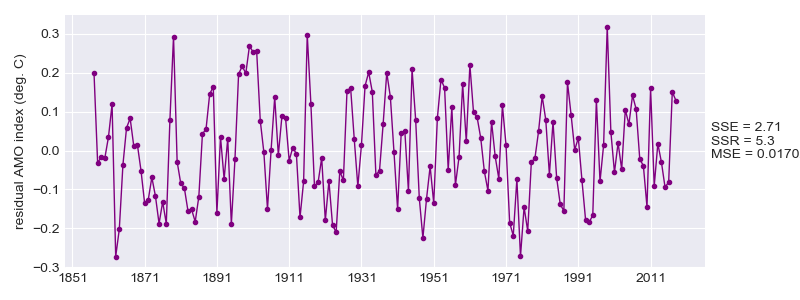

In [8]:
period = popt[-2]  # in years
phase  = popt[-1] #% period  # years

y = df_reg['amo'].values  # AMO index: annual mean of monthly mean AMO

x0 = np.ones(df_reg['amo'].shape)  # intercept
x1 = np.copy(df_reg['year'].values)  # year
x2 = np.sin(2*np.pi/period*(x1-phase))  # oscillation with prescribed period and phase
x1[x1 < 1900] = 1900  # this is the only change!! in the linear model setup wrt (2)

#X = np.vstack((x2, x1, x0)).T
X = pd.DataFrame(data={'0-const': x0, '1-year': x1, '2-oscillation': x2})

res = sm.OLS(y, X).fit()  # model fit (coefficients etc.) for the least-squares soln

#> compute confidence and prediction intervals for the predicted
#  x: year
#  y: AMO
n = len(df_reg.index)
x = df_reg['year'].values
x_bar = x.mean()
s_x = np.sqrt( np.sum((x-x_bar)**2) / (n-1) )  # x.std() does population version
y_hat = np.dot(X, res.params)
resid = y - y_hat
df_resid = n - 3  # 3 predictors; or can use res.df_resid from StatsModels results
s_y = np.sqrt( np.sum(resid**2) / df_resid )  # standard error (deviation) of the residuals
t_star = ss.t.ppf(1-0.05/2, df_resid)
conf_pm = t_star * s_y * np.sqrt( 1/n + ((x-x_bar)**2)/((n-1)*s_x**2) )
conf_int = (y_hat-conf_pm, y_hat+conf_pm) 
#pred_pm = t_star * s_y * np.sqrt( 1 + 1/n + ((x-x_bar)**2)/((n-1)*s_x**2) )
pred_pm = t_star * s_y * np.sqrt( 1 + 1/n + ((x-x_bar)**2)/(np.sum((x-x_bar)**2)) )
pred_int = (y_hat-pred_pm, y_hat+pred_pm)

f3, a = plt.subplots(figsize=figsize, num='ts_ols4')

print(res.summary())

param_lines = '\n'.join([r'$\beta_{:d} = {{:.3g}} \pm {{:.3g}}$'.format(i) for i in range(len(res.params))])
s = r'''
$y = \beta_2 \sin\left( \frac{{2 \pi}}{{\mathrm{{period}}}} (t - \mathrm{{phase}}) \right)$ 
      $+ \beta_1 t + \beta_0$
      
period = {:.4g}
phase = {:.4g}
'''# + param_lines#).format(period, phase *stuff)
s = s.format(period, phase, *chain.from_iterable(zip(res.params, res.bse)))

a.plot(amo_annual_mean['amo'], 'b.-', alpha=0.6, ms=6, lw=1, label='annual means')
a.plot(t_plot, y_hat, '-', c='r', lw=2, label=s)
a.plot(t_plot, conf_int[0], 'orange', lw=1.2, label='95% confidence interval\nfor the regression')
a.plot(t_plot, conf_int[1], 'orange', lw=1.2)
a.plot(t_plot, pred_int[0], 'green', lw=1.0, label='95% prediction interval\nfor the predictand')
a.plot(t_plot, pred_int[1], 'green', lw=1.0)

a.set_ylabel('AMO index (deg. C)')
a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f3.tight_layout();

f3b, a = plt.subplots(figsize=figsize_res, num='ts_ols4_res')

y_bar = y.mean()
SSE = np.sum((y-y_hat)**2)  # sum of squared error
SSR = np.sum((y_hat-y_bar)**2)  # residual sum of squares
SST = np.sum((y-y_bar)**2)
assert( np.isclose(SST, SSE+SSR) )
MSE = SSE/(res.df_resid)  # MSE == sample variance of the residuals
assert( np.isclose(MSE, res.mse_resid) )  # res.mse_model == MSR; F = MSR/MSE
s = '''
SSE = {:.3g}
SSR = {:.3g}
MSE = {:.4g}
'''.format(SSE, SSR, MSE)  

a.plot(t_plot, y-y_hat, '.-', c='purple', ms=6, lw=1, label=s)
a.set_ylabel('residual AMO index (deg. C)')
a.text(1.01, 0.5, s,
       va='center', ha='left', transform=a.transAxes)
#a.legend(loc='center left', bbox_to_anchor=(0.99, 0.5), labelspacing=1.5)

f3b.tight_layout(rect=(0, 0, 0.9, 1.0));

## To save figures locally if you wish...

Probably a silly thing for a Jupyter Notebook to do but whatever

Put the code in a cell and run it to save the figs to local dir 'figs'.

```python
#> save figs; requires that the 'figs' dir exists..
for n in plt.get_fignums():
    f = plt.figure(n)
    f.savefig('./figs/hw2p2_{:s}.pdf'.format(f.get_label()), 
        transparent=False, 
        bbox_inches='tight', pad_inches=0.05,
        )
```